# 03 - Обучение и оценка модели детекции факелов
## Тренировка YOLO модели на COCO датасетах и оценка эффективности

**Цель:** Обучить модель детекции факелов на подготовленных COCO датасетах и оценить её качество для последующей интеграции в пайплайн оценки выбросов.

**Задачи:**
1. Подготовить данные в формате YOLO из COCO аннотаций
2. Выбрать и настроить предобученную модель YOLO
3. Провести дообучение (fine-tuning) на наших данных
4. Валидация и оценка метрик (mAP@0.5, Precision, Recall)
5. Тестирование на отдельной выборке
6. Анализ ошибок и рекомендации по улучшению

## 1. Настройка окружения и импорт библиотек

In [2]:
import sys
import os
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
import yaml
import json
import warnings
warnings.filterwarnings('ignore')

# Добавляем пути
project_root = Path("E:/Python/MIFI/project-practice/")
src_path = project_root / "src"
sys.path.append(str(src_path))

# Для YOLO
import torch
import ultralytics
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors
from ultralytics.utils.metrics import ConfusionMatrix

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
import cv2
from tqdm.auto import tqdm
import random
from datetime import datetime
from dataclasses import dataclass
from collections import defaultdict
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Настройка отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Пути к данным согласно архитектуре проекта
DATA_BASE_PATH = project_root / "data" / "labeled"
MODELS_DIR = project_root / "models"
PRETRAINED_MODELS_DIR = MODELS_DIR / "pretrained"
TRAINED_MODELS_DIR = MODELS_DIR / "trained"
DETECTION_MODEL_DIR = TRAINED_MODELS_DIR / "detection_model"
OUTPUT_DIR = project_root / "output"

# Создаем директории если их нет
for dir_path in [DATA_BASE_PATH, PRETRAINED_MODELS_DIR, DETECTION_MODEL_DIR, OUTPUT_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("📁 Архитектура проекта:")
print(f"  • Корневая директория: {project_root}")
print(f"  • Данные: {DATA_BASE_PATH}")
print(f"  • Модели: {MODELS_DIR}")
print(f"  • Предобученные модели: {PRETRAINED_MODELS_DIR}")
print(f"  • Обученные модели: {TRAINED_MODELS_DIR}")
print(f"  • Модель детекции: {DETECTION_MODEL_DIR}")
print(f"  • Выводы: {OUTPUT_DIR}")


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\Vlaso\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
📁 Архитектура проекта:
  • Корневая директория: E:\Python\MIFI\project-practice
  • Данные: E:\Python\MIFI\project-practice\data\labeled
  • Модели: E:\Python\MIFI\project-practice\models
  • Предобученные модели: E:\Python\MIFI\project-practice\models\pretrained
  • Обученные модели: E:\Python\MIFI\project-practice\models\trained
  • Модель детекции: E:\Python\MIFI\project-practice\models\trained\detection_model
  • Выводы: E:\Python\MIFI\project-practice\output


In [4]:
# Проверка доступности GPU
print("\n" + "=" * 60)
print("ПРОВЕРКА АППАРАТНОГО ОБЕСПЕЧЕНИЯ")
print("=" * 60)
print(f"PyTorch версия: {torch.__version__}")
print(f"Ultralytics версия: {ultralytics.__version__}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU доступен: {gpu_name}")
    print(f"   Память GPU: {gpu_memory:.2f} GB")
    device = 'cuda'
    device_name = gpu_name
else:
    print("⚠️ GPU не доступен, будет использоваться CPU")
    device = 'cpu'
    device_name = 'CPU'


ПРОВЕРКА АППАРАТНОГО ОБЕСПЕЧЕНИЯ
PyTorch версия: 2.9.1+cpu
Ultralytics версия: 8.3.237
⚠️ GPU не доступен, будет использоваться CPU


In [6]:
# Загрузка конфигурации
config_path = project_root / "configs" / "paths.yaml"
if config_path.exists():
    with open(config_path, "r", encoding='utf-8') as f:
        config = yaml.safe_load(f)
    print(f"\n✅ Загружена конфигурация из {config_path}")
else:
    print(f"\n⚠️ Конфигурационный файл не найден, создаем стандартный...")
    config = {
        'data': {
            'base_path': str(DATA_BASE_PATH),
            'output_dir': str(OUTPUT_DIR)
        },
        'model': {
            'pretrained_path': str(PRETRAINED_MODELS_DIR),
            'trained_path': str(DETECTION_MODEL_DIR)
        }
    }
    # Сохраняем конфигурацию
    config_path.parent.mkdir(parents=True, exist_ok=True)
    with open(config_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)


✅ Загружена конфигурация из E:\Python\MIFI\project-practice\configs\paths.yaml


## 2. Подготовка данных для обучения YOLO
### 2.1. Загрузка и анализ COCO датасетов

In [7]:
def load_coco_annotations(coco_json_path: Path) -> pd.DataFrame:
    """Загружает аннотации в формате COCO JSON"""
    
    if not coco_json_path.exists():
        print(f"⚠️ Файл не найден: {coco_json_path}")
        return pd.DataFrame()
    
    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)
    
    annotations = []
    
    # Создаем словари для быстрого поиска
    images_dict = {img['id']: img for img in coco_data['images']}
    categories_dict = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    print(f"  • Загружено {len(coco_data['images'])} изображений")
    print(f"  • Загружено {len(coco_data['annotations'])} аннотаций")
    print(f"  • Классы: {[cat['name'] for cat in coco_data['categories']]}")
    
    for ann in tqdm(coco_data['annotations'], desc=f"Загрузка аннотаций"):
        img_info = images_dict[ann['image_id']]
        
        # COCO формат: [x_min, y_min, width, height]
        x_min, y_min, width, height = ann['bbox']
        x_max = x_min + width
        y_max = y_min + height
        x_center = x_min + width / 2
        y_center = y_min + height / 2
        
        annotations.append({
            'image_id': ann['image_id'],
            'image_name': img_info['file_name'],
            'image_width': img_info['width'],
            'image_height': img_info['height'],
            'class_id': ann['category_id'],
            'class_name': categories_dict[ann['category_id']],
            'x_center': x_center,
            'y_center': y_center,
            'width': width,
            'height': height,
            'x_min': x_min,
            'y_min': y_min,
            'x_max': x_max,
            'y_max': y_max,
            'area': ann['area'],
            'aspect_ratio': width / height if height > 0 else 0,
            'bbox': ann['bbox'],
            'iscrowd': ann['iscrowd']
        })
    
    return pd.DataFrame(annotations)

In [8]:
def analyze_dataset_statistics(df: pd.DataFrame, split_name: str) -> Dict:
    """Анализирует статистику датасета"""
    
    stats = {
        'split': split_name,
        'total_images': df['image_name'].nunique(),
        'total_annotations': len(df),
        'avg_annotations_per_image': len(df) / df['image_name'].nunique() if len(df) > 0 else 0,
        'class_distribution': df['class_name'].value_counts().to_dict(),
        'image_sizes': df[['image_width', 'image_height']].drop_duplicates().to_dict('records'),
        'bbox_stats': {
            'min_area': df['area'].min() if len(df) > 0 else 0,
            'max_area': df['area'].max() if len(df) > 0 else 0,
            'mean_area': df['area'].mean() if len(df) > 0 else 0,
            'mean_aspect_ratio': df['aspect_ratio'].mean() if len(df) > 0 else 0
        }
    }
    
    return stats

In [10]:
print("\n" + "="*60)
print("АНАЛИЗ ДАТАСЕТОВ")
print("="*60)

# Проверяем наличие данных
splits = ['train', 'valid', 'test']
all_data = {}
dataset_stats = []

for split in splits:
    coco_json_path = DATA_BASE_PATH / split / '_annotations.coco.json'
    images_dir = DATA_BASE_PATH / split
    
    if coco_json_path.exists() and images_dir.exists():
        print(f"\n📂 Загрузка {split} датасета...")
        
        # Загружаем аннотации
        df = load_coco_annotations(coco_json_path)
        
        if not df.empty:
            df['split'] = split
            all_data[split] = df
            
            # Анализируем статистику
            stats = analyze_dataset_statistics(df, split)
            dataset_stats.append(stats)
            
            # Проверяем соответствие файлов изображений
            image_files = list(images_dir.glob('*'))
            missing_images = set(df['image_name']) - {f.name for f in image_files}
            
            if missing_images:
                print(f"  ⚠️ Отсутствуют {len(missing_images)} изображений из аннотаций")
            
            print(f"  ✅ Успешно загружено")
        else:
            print(f"  ⚠️ Нет аннотаций в файле")
    else:
        print(f"\n❌ {split} датасет не найден:")
        print(f"   • Аннотации: {coco_json_path}")
        print(f"   • Изображения: {images_dir}")


АНАЛИЗ ДАТАСЕТОВ

📂 Загрузка train датасета...
  • Загружено 987 изображений
  • Загружено 2319 аннотаций
  • Классы: ['flare', 'fire', 'smoke']


Загрузка аннотаций:   0%|          | 0/2319 [00:00<?, ?it/s]

  ✅ Успешно загружено

📂 Загрузка valid датасета...
  • Загружено 40 изображений
  • Загружено 97 аннотаций
  • Классы: ['flare', 'fire', 'smoke']


Загрузка аннотаций:   0%|          | 0/97 [00:00<?, ?it/s]

  ✅ Успешно загружено

📂 Загрузка test датасета...
  • Загружено 19 изображений
  • Загружено 48 аннотаций
  • Классы: ['flare', 'fire', 'smoke']


Загрузка аннотаций:   0%|          | 0/48 [00:00<?, ?it/s]

  ✅ Успешно загружено



СВОДНАЯ СТАТИСТИКА ДАТАСЕТОВ


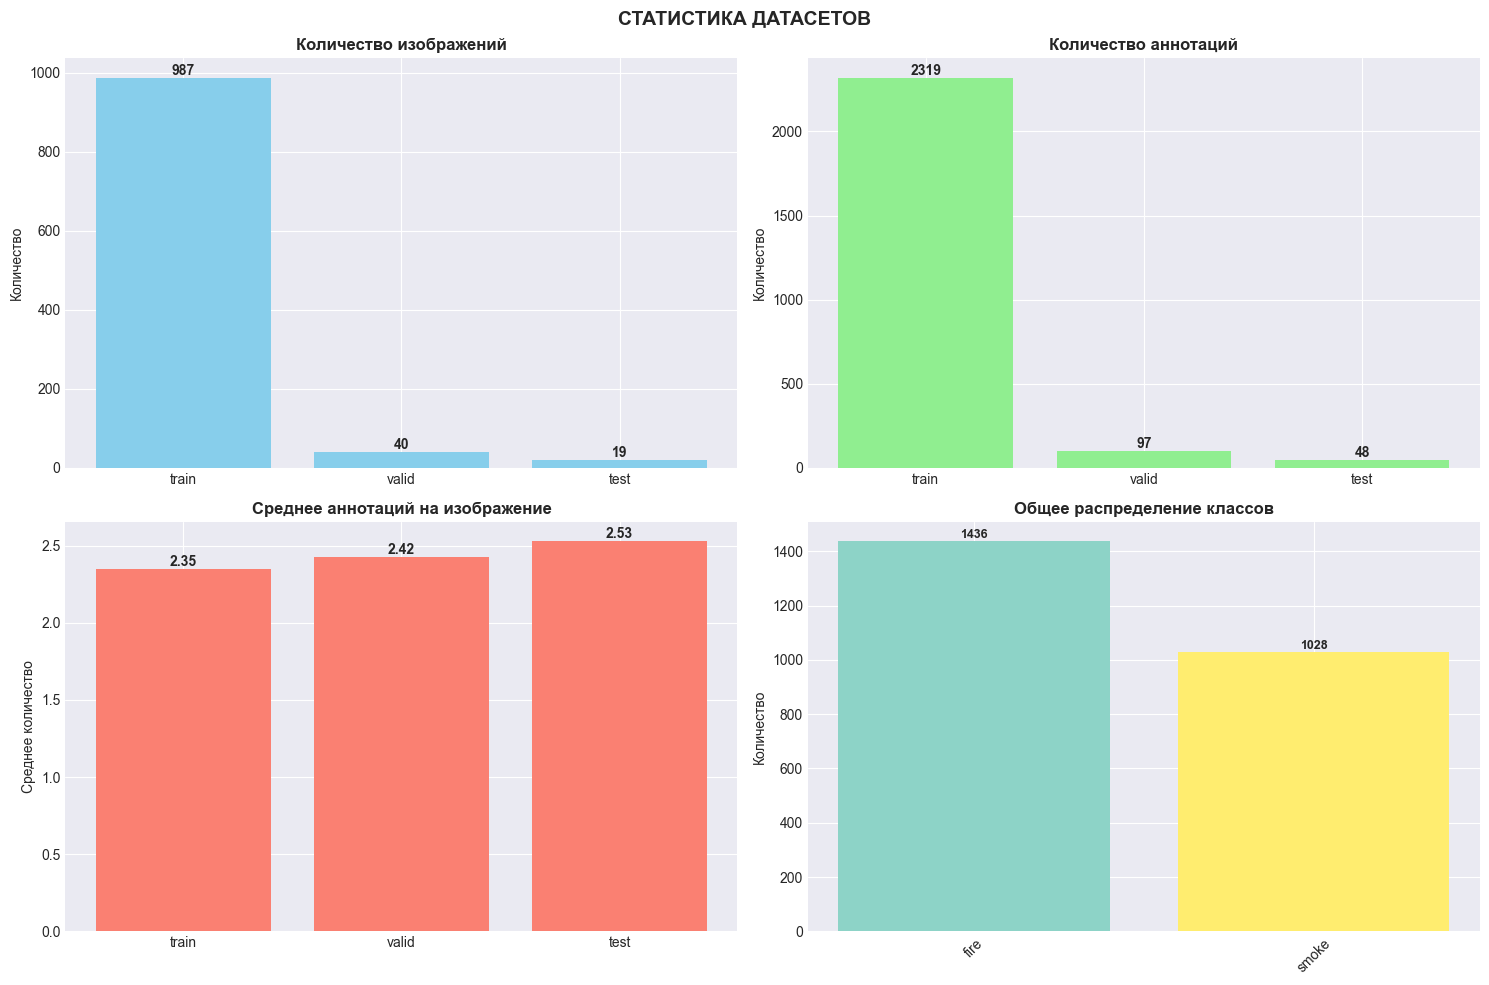


📊 Детальная статистика:

TRAIN:
  • Изображений: 987
  • Аннотаций: 2319
  • Среднее на изображение: 2.35
  • Распределение классов:
    - fire: 1349 (58.2%)
    - smoke: 970 (41.8%)

VALID:
  • Изображений: 40
  • Аннотаций: 97
  • Среднее на изображение: 2.42
  • Распределение классов:
    - fire: 58 (59.8%)
    - smoke: 39 (40.2%)

TEST:
  • Изображений: 19
  • Аннотаций: 48
  • Среднее на изображение: 2.53
  • Распределение классов:
    - fire: 29 (60.4%)
    - smoke: 19 (39.6%)


In [11]:
# Сводная статистика по всем датасетам
if dataset_stats:
    print("\n" + "="*60)
    print("СВОДНАЯ СТАТИСТИКА ДАТАСЕТОВ")
    print("="*60)
    
    stats_df = pd.DataFrame(dataset_stats)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Количество изображений
    axes[0, 0].bar(stats_df['split'], stats_df['total_images'], color='skyblue')
    axes[0, 0].set_title('Количество изображений', fontweight='bold')
    axes[0, 0].set_ylabel('Количество')
    for i, v in enumerate(stats_df['total_images']):
        axes[0, 0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
    
    # 2. Количество аннотаций
    axes[0, 1].bar(stats_df['split'], stats_df['total_annotations'], color='lightgreen')
    axes[0, 1].set_title('Количество аннотаций', fontweight='bold')
    axes[0, 1].set_ylabel('Количество')
    for i, v in enumerate(stats_df['total_annotations']):
        axes[0, 1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
    
    # 3. Среднее аннотаций на изображение
    axes[1, 0].bar(stats_df['split'], stats_df['avg_annotations_per_image'], color='salmon')
    axes[1, 0].set_title('Среднее аннотаций на изображение', fontweight='bold')
    axes[1, 0].set_ylabel('Среднее количество')
    for i, v in enumerate(stats_df['avg_annotations_per_image']):
        axes[1, 0].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Распределение классов (сводное)
    all_classes = {}
    for stats in dataset_stats:
        for class_name, count in stats['class_distribution'].items():
            all_classes[class_name] = all_classes.get(class_name, 0) + count
    
    if all_classes:
        classes = list(all_classes.keys())
        counts = list(all_classes.values())
        colors_bars = plt.cm.Set3(np.linspace(0, 1, len(classes)))
        axes[1, 1].bar(classes, counts, color=colors_bars)
        axes[1, 1].set_title('Общее распределение классов', fontweight='bold')
        axes[1, 1].set_ylabel('Количество')
        axes[1, 1].tick_params(axis='x', rotation=45)
        for i, v in enumerate(counts):
            axes[1, 1].text(i, v, str(v), ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.suptitle('СТАТИСТИКА ДАТАСЕТОВ', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Текстовая статистика
    print("\n📊 Детальная статистика:")
    for stats in dataset_stats:
        print(f"\n{stats['split'].upper()}:")
        print(f"  • Изображений: {stats['total_images']}")
        print(f"  • Аннотаций: {stats['total_annotations']}")
        print(f"  • Среднее на изображение: {stats['avg_annotations_per_image']:.2f}")
        print(f"  • Распределение классов:")
        for class_name, count in stats['class_distribution'].items():
            percentage = (count / stats['total_annotations']) * 100
            print(f"    - {class_name}: {count} ({percentage:.1f}%)")


## 3. Подготовка данных в формате YOLO

In [12]:
def prepare_yolo_dataset(all_data: Dict[str, pd.DataFrame], output_dir: Path):
    """Подготавливает датасет в формате YOLO из COCO аннотаций"""
    
    print("\n" + "="*60)
    print("ПОДГОТОВКА ДАТАСЕТА В ФОРМАТЕ YOLO")
    print("="*60)
    
    # Определяем все классы из всех сплитов
    all_classes = set()
    for df in all_data.values():
        all_classes.update(df['class_name'].unique())
    
    class_names = sorted(list(all_classes))
    class_to_id = {name: idx for idx, name in enumerate(class_names)}
    
    print(f"📋 Классы детекции ({len(class_names)}):")
    for class_id, class_name in enumerate(class_names):
        print(f"  • {class_id}: {class_name}")
    
    # Подготовка каждого сплита
    for split, df in all_data.items():
        print(f"\n🔄 Подготовка {split} датасета...")
        
        # Создаем директории
        images_dir = output_dir / split / 'images'
        labels_dir = output_dir / split / 'labels'
        images_dir.mkdir(parents=True, exist_ok=True)
        labels_dir.mkdir(parents=True, exist_ok=True)
        
        processed_images = 0
        missing_images = 0
        
        # Обрабатываем каждое изображение
        for image_name, group in tqdm(df.groupby('image_name'), desc=f"Обработка {split}"):
            # Путь к исходному изображению
            src_image_path = DATA_BASE_PATH / split / image_name
            
            if src_image_path.exists():
                # Копируем изображение
                dst_image_path = images_dir / image_name
                shutil.copy2(src_image_path, dst_image_path)
                
                # Создаем файл аннотаций YOLO
                label_file = labels_dir / f"{Path(image_name).stem}.txt"
                
                with open(label_file, 'w', encoding='utf-8') as f:
                    for _, ann in group.iterrows():
                        # Конвертируем в относительные координаты YOLO
                        x_center_rel = ann['x_center'] / ann['image_width']
                        y_center_rel = ann['y_center'] / ann['image_height']
                        width_rel = ann['width'] / ann['image_width']
                        height_rel = ann['height'] / ann['image_height']
                        
                        # YOLO формат: class_id x_center y_center width height
                        yolo_id = class_to_id[ann['class_name']]
                        f.write(f"{yolo_id} {x_center_rel:.6f} {y_center_rel:.6f} "
                               f"{width_rel:.6f} {height_rel:.6f}\n")
                
                processed_images += 1
            else:
                missing_images += 1
        
        print(f"  ✅ Обработано изображений: {processed_images}")
        if missing_images > 0:
            print(f"  ⚠️ Пропущено изображений: {missing_images}")
    
    # Создаем dataset.yaml файл
    create_yolo_dataset_yaml(output_dir, class_names)
    
    return class_to_id

In [13]:
def create_yolo_dataset_yaml(output_dir: Path, class_names: List[str]):
    """Создает dataset.yaml файл для YOLO"""
    
    dataset_yaml = {
        'path': str(output_dir.absolute()),
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        'nc': len(class_names),
        'names': class_names
    }
    
    yaml_path = output_dir / 'dataset.yaml'
    with open(yaml_path, 'w', encoding='utf-8') as f:
        yaml.dump(dataset_yaml, f, default_flow_style=False, allow_unicode=True)
    
    print(f"\n✅ Создан файл конфигурации датасета:")
    print(f"   • Путь: {yaml_path}")
    print(f"   • Классы: {class_names}")
    print(f"   • Количество классов: {len(class_names)}")


# Подготавливаем датасет YOLO

In [14]:
if all_data:
    YOLO_DATASET_DIR = OUTPUT_DIR / "yolo_dataset"
    class_to_id = prepare_yolo_dataset(all_data, YOLO_DATASET_DIR)
    
    print(f"\n✅ Датaсет YOLO подготовлен:")
    print(f"   • Директория: {YOLO_DATASET_DIR}")
    print(f"   • Структура:")
    for split in ['train', 'valid', 'test']:
        split_dir = YOLO_DATASET_DIR / split
        if split_dir.exists():
            images_count = len(list((split_dir / 'images').glob('*')))
            labels_count = len(list((split_dir / 'labels').glob('*.txt')))
            print(f"     - {split}: {images_count} изображений, {labels_count} файлов разметки")
else:
    print("❌ Нет данных для подготовки датасета")


ПОДГОТОВКА ДАТАСЕТА В ФОРМАТЕ YOLO
📋 Классы детекции (2):
  • 0: fire
  • 1: smoke

🔄 Подготовка train датасета...


Обработка train:   0%|          | 0/987 [00:00<?, ?it/s]

  ✅ Обработано изображений: 987

🔄 Подготовка valid датасета...


Обработка valid:   0%|          | 0/40 [00:00<?, ?it/s]

  ✅ Обработано изображений: 40

🔄 Подготовка test датасета...


Обработка test:   0%|          | 0/19 [00:00<?, ?it/s]

  ✅ Обработано изображений: 19

✅ Создан файл конфигурации датасета:
   • Путь: E:\Python\MIFI\project-practice\output\yolo_dataset\dataset.yaml
   • Классы: ['fire', 'smoke']
   • Количество классов: 2

✅ Датaсет YOLO подготовлен:
   • Директория: E:\Python\MIFI\project-practice\output\yolo_dataset
   • Структура:
     - train: 987 изображений, 987 файлов разметки
     - valid: 40 изображений, 40 файлов разметки
     - test: 19 изображений, 19 файлов разметки


## 4. Выбор и настройка модели YOLO

In [15]:
def download_pretrained_yolo_models():
    """Скачивает предобученные модели YOLO если их нет"""
    
    print("\n" + "="*60)
    print("ПРОВЕРКА ПРЕДОБУЧЕННЫХ МОДЕЛЕЙ")
    print("="*60)
    
    # Модели YOLOv8 для детекции
    yolo_models = {
        'yolov8n': 'yolov8n.pt',  # nano - самый быстрый
        'yolov8s': 'yolov8s.pt',  # small - хороший баланс
        'yolov8m': 'yolov8m.pt',  # medium - хорошая точность
        'yolov8l': 'yolov8l.pt',  # large - высокая точность
        'yolov8x': 'yolov8x.pt',  # xlarge - максимальная точность
    }
    
    available_models = {}
    
    for model_name, filename in yolo_models.items():
        model_path = PRETRAINED_MODELS_DIR / filename
        
        if model_path.exists():
            print(f"✅ {model_name}: уже скачан ({model_path.stat().st_size / 1e6:.1f} MB)")
            available_models[model_name] = model_path
        else:
            print(f"⬇️  {model_name}: скачивание...")
            try:
                # Скачиваем модель через ultralytics
                model = YOLO(f"{filename}")
                torch.save(model.model.state_dict(), model_path)
                print(f"✅ {model_name}: успешно скачан")
                available_models[model_name] = model_path
            except Exception as e:
                print(f"❌ {model_name}: ошибка скачивания - {e}")
    
    return available_models

In [17]:
# Скачиваем предобученные модели
available_models = download_pretrained_yolo_models()

if available_models:
    print(f"\n✅ Доступно {len(available_models)} предобученных моделей:")
    for model_name, model_path in available_models.items():
        print(f"  • {model_name}: {model_path}")
else:
    print("\n⚠️ Нет доступных предобученных моделей")


ПРОВЕРКА ПРЕДОБУЧЕННЫХ МОДЕЛЕЙ
✅ yolov8n: уже скачан (12.8 MB)
✅ yolov8s: уже скачан (44.9 MB)
✅ yolov8m: уже скачан (103.9 MB)
✅ yolov8l: уже скачан (175.1 MB)
✅ yolov8x: уже скачан (273.3 MB)

✅ Доступно 5 предобученных моделей:
  • yolov8n: E:\Python\MIFI\project-practice\models\pretrained\yolov8n.pt
  • yolov8s: E:\Python\MIFI\project-practice\models\pretrained\yolov8s.pt
  • yolov8m: E:\Python\MIFI\project-practice\models\pretrained\yolov8m.pt
  • yolov8l: E:\Python\MIFI\project-practice\models\pretrained\yolov8l.pt
  • yolov8x: E:\Python\MIFI\project-practice\models\pretrained\yolov8x.pt


In [18]:
def select_model_for_training(available_models: Dict, selection_criteria: str = 'balance') -> Tuple[str, Path]:
    """Выбирает модель для обучения на основе критериев"""
    
    model_selection = {
        'speed': 'yolov8n',      # для быстрой инференса
        'balance': 'yolov8s',    # баланс скорости и точности (рекомендуется)
        'accuracy': 'yolov8m',   # для максимальной точности
        'high_accuracy': 'yolov8l',  # для сложных задач
    }
    
    selected_model_name = model_selection.get(selection_criteria, 'yolov8s')
    
    if selected_model_name in available_models:
        selected_model_path = available_models[selected_model_name]
        print(f"\n✅ Выбрана модель: {selected_model_name}")
        print(f"   • Критерий выбора: {selection_criteria}")
        print(f"   • Путь к модели: {selected_model_path}")
        return selected_model_name, selected_model_path
    else:
        # Если выбранная модель не доступна, берем первую доступную
        fallback_model = list(available_models.keys())[0]
        print(f"\n⚠️ Выбранная модель не доступна, используем {fallback_model}")
        return fallback_model, available_models[fallback_model]

In [19]:
# Выбираем модель для обучения
SELECTED_MODEL_NAME, SELECTED_MODEL_PATH = select_model_for_training(
    available_models, 
    selection_criteria='balance'  # хороший баланс скорости и точности
)

print(f"\n🎯 Модель для обучения: {SELECTED_MODEL_NAME}")
print(f"   • Идеально подходит для детекции факелов")
print(f"   • Хороший баланс скорости и точности")
print(f"   • Поддерживает дообучение (fine-tuning)")



✅ Выбрана модель: yolov8s
   • Критерий выбора: balance
   • Путь к модели: E:\Python\MIFI\project-practice\models\pretrained\yolov8s.pt

🎯 Модель для обучения: yolov8s
   • Идеально подходит для детекции факелов
   • Хороший баланс скорости и точности
   • Поддерживает дообучение (fine-tuning)


## 5. Конфигурация обучения модели

In [20]:
def create_training_config(
    model_name: str,
    dataset_path: Path,
    project_name: str,
    device: str = 'cpu',
    **kwargs
) -> Dict:
    """Создает конфигурацию для обучения YOLO модели"""
    
    # Базовые параметры для детекции факелов
    base_config = {
        # Пути и основные параметры
        'data': str(dataset_path / 'dataset.yaml'),
        'project': str(OUTPUT_DIR / 'training'),
        'name': f"{model_name}_{datetime.now().strftime('%Y%m%d_%H%M')}",
        'model': str(SELECTED_MODEL_PATH),
        
        # Гиперпараметры обучения
        'epochs': 100,
        'patience': 30,  # ранняя остановка если нет улучшений
        'batch': 16 if device == 'cuda' else 8,
        'imgsz': 640,  # размер изображения
        'device': device,
        
        # Параметры оптимизатора
        'lr0': 0.01,  # начальный learning rate
        'lrf': 0.01,  # финальный learning rate = lr0 * lrf
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        
        # Аугментация данных (особенно важна для факелов)
        'hsv_h': 0.015,  # изменение оттенка
        'hsv_s': 0.7,    # изменение насыщенности
        'hsv_v': 0.4,    # изменение яркости
        'degrees': 0.0,  # вращение (для факелов лучше отключить)
        'translate': 0.1,  # сдвиг
        'scale': 0.5,    # масштабирование
        'shear': 0.0,    # сдвиг
        'perspective': 0.0,  # перспективное искажение
        'flipud': 0.0,   # отражение по вертикали
        'fliplr': 0.5,   # отражение по горизонтали
        'mosaic': 1.0,   # mosaic аугментация
        'mixup': 0.0,    # mixup аугментация
        
        # Детекция мелких объектов (важно для маленьких факелов)
        'anchor_t': 4.0,  # anchor threshold
        'fl_gamma': 0.0,  # focal loss gamma
        
        # Дополнительные параметры
        'save': True,
        'save_period': -1,
        'cache': False,
        'workers': 8,
        'pretrained': True,
        'optimizer': 'SGD',  # SGD лучше для дообучения
        'verbose': True,
        'seed': 42,
        'deterministic': True,
        'single_cls': False,
        'rect': False,
        'cos_lr': False,
        'label_smoothing': 0.0,
        'overlap_mask': True,
        'mask_ratio': 4,
        'dropout': 0.0,
        'val': True,
        'plots': True,
        'exist_ok': True,
    }
    
    # Обновляем пользовательскими параметрами
    base_config.update(kwargs)
    
    return base_config

In [21]:
# Создаем конфигурацию обучения
training_config = create_training_config(
    model_name=SELECTED_MODEL_NAME,
    dataset_path=YOLO_DATASET_DIR,
    project_name='flare_detection',
    device=device,
    epochs=50,  # Можно увеличить для лучшего качества
    batch=8,    # Уменьшаем batch если мало памяти
    lr0=0.001,  # Меньше learning rate для стабильного дообучения
    patience=15,  # Ранняя остановка
    fliplr=0.3,   # Меньше горизонтального отражения
    mosaic=0.5,   # Меньше mosaic аугментации
)

print("\n" + "="*60)
print("КОНФИГУРАЦИЯ ОБУЧЕНИЯ")
print("="*60)

print("\n📋 Основные параметры:")
important_params = [
    'model', 'epochs', 'batch', 'imgsz', 'device',
    'lr0', 'data', 'project', 'name'
]
for param in important_params:
    if param in training_config:
        print(f"  • {param}: {training_config[param]}")

print("\n⚙️ Параметры оптимизации:")
opt_params = ['lr0', 'lrf', 'momentum', 'weight_decay', 'optimizer']
for param in opt_params:
    if param in training_config:
        print(f"  • {param}: {training_config[param]}")

print("\n🎨 Параметры аугментации:")
aug_params = ['hsv_h', 'hsv_s', 'hsv_v', 'fliplr', 'mosaic', 'scale']
for param in aug_params:
    if param in training_config:
        print(f"  • {param}: {training_config[param]}")


КОНФИГУРАЦИЯ ОБУЧЕНИЯ

📋 Основные параметры:
  • model: E:\Python\MIFI\project-practice\models\pretrained\yolov8s.pt
  • epochs: 50
  • batch: 8
  • imgsz: 640
  • device: cpu
  • lr0: 0.001
  • data: E:\Python\MIFI\project-practice\output\yolo_dataset\dataset.yaml
  • project: E:\Python\MIFI\project-practice\output\training
  • name: yolov8s_20251215_0147

⚙️ Параметры оптимизации:
  • lr0: 0.001
  • lrf: 0.01
  • momentum: 0.937
  • weight_decay: 0.0005
  • optimizer: SGD

🎨 Параметры аугментации:
  • hsv_h: 0.015
  • hsv_s: 0.7
  • hsv_v: 0.4
  • fliplr: 0.3
  • mosaic: 0.5
  • scale: 0.5


In [22]:
# Сохраняем конфигурацию
config_save_path = DETECTION_MODEL_DIR / 'training_config.yaml'
with open(config_save_path, 'w', encoding='utf-8') as f:
    yaml.dump(training_config, f, default_flow_style=False, allow_unicode=True)
print(f"\n✅ Конфигурация сохранена: {config_save_path}")


✅ Конфигурация сохранена: E:\Python\MIFI\project-practice\models\trained\detection_model\training_config.yaml


## 6. Обучение модели (Fine-tuning)

In [40]:
def train_yolo_model(config: Dict) -> Tuple[Optional[YOLO], Dict]:
    """Обучает модель YOLO с заданной конфигурацией"""
    
    print("\n" + "="*60)
    print("НАЧАЛО ОБУЧЕНИЯ МОДЕЛИ (FINE-TUNING)")
    print("="*60)
    
    start_time = datetime.now()
    
    # Создаем директорию для эксперимента
    exp_dir = Path(config['project']) / config['name']
    exp_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"📁 Эксперимент: {config['name']}")
    print(f"📁 Выходная директория: {exp_dir}")
    
    # Проверяем наличие данных
    if not Path(config['data']).exists():
        print(f"❌ Файл датасета не найден: {config['data']}")
        return None, {}
    
    # Проверяем наличие модели
    model_path = Path(config['model'])
    if not model_path.exists():
        print(f"❌ Файл модели не найден: {model_path}")
        print("Пробуем загрузить модель из репозитория Ultralytics...")
        # Если файл не найден, пробуем загрузить по имени модели
        model_name = "yolov8s.pt"
    else:
        model_name = str(model_path)
    
    # Загружаем модель
    print(f"\n🔄 Загрузка предобученной модели...")
    try:
        # Пробуем разные способы загрузки модели
        model = YOLO(model_name)
        print(f"✅ Модель загружена успешно!")
        print(f"   • Тип модели: {type(model).__name__}")
        if hasattr(model, 'names'):
            print(f"   • Количество классов: {len(model.names)}")
            print(f"   • Имена классов: {list(model.names.values())[:5]}...")
    except Exception as e:
        print(f"❌ Ошибка загрузки модели: {e}")
        print("Пробуем другой способ загрузки...")
        try:
            # Пробуем загрузить через torch
            import torch
            model = YOLO('yolov8s.yaml')
            model.load('yolov8s.pt')
            print("✅ Модель загружена через YAML+weights")
        except Exception as e2:
            print(f"❌ Вторая попытка также не удалась: {e2}")
            return None, {}
    
    # Обучаем модель
    print(f"\n🎯 Начало обучения на {config['epochs']} эпох...")
    print(f"   • Устройство: {config.get('device', 'cuda' if torch.cuda.is_available() else 'cpu')}")
    print(f"   • Batch size: {config['batch']}")
    print(f"   • Размер изображения: {config['imgsz']}")
    
    try:
        # Удаляем ключ 'model' из конфига, так как модель уже загружена
        train_config = config.copy()
        train_config.pop('model', None)
        
        results = model.train(**train_config)
        print("\n✅ Обучение завершено успешно!")
    except Exception as e:
        print(f"❌ Ошибка при обучении: {e}")
        import traceback
        traceback.print_exc()
        return None, {}
    
    training_time = datetime.now() - start_time
    
    print(f"\n⏱️  Время обучения: {training_time}")
    print(f"📁 Результаты сохранены в: {exp_dir}")
    
    # Копируем лучшую модель
    best_model_path = exp_dir / 'weights' / 'best.pt'
    if best_model_path.exists():
        target_model_dir = DETECTION_MODEL_DIR / 'weights'
        target_model_dir.mkdir(parents=True, exist_ok=True)
        target_path = target_model_dir / f"best_{config['name']}.pt"
        shutil.copy2(best_model_path, target_path)
        print(f"✅ Лучшая модель сохранена: {target_path}")
    
    return model, results

In [42]:
# Обновленная конфигурация
YOLO_MODEL_PATH = Path("E:\Python\MIFI\project-practice\models\pretrained\yolov8s.pt")  # Используем относительный путь

training_config = {
    'model': str(YOLO_MODEL_PATH),
    'data': str(YOLO_DATASET_DIR / 'dataset.yaml'),  # Убедитесь, что файл называется data.yaml, а не dataset.yaml
    'epochs': 50,
    'imgsz': 640,
    'batch': 8,  # Уменьшите batch size если мало памяти
    'workers': 2,
    'project': 'runs/detect',
    'name': 'train',
    'exist_ok': True,
    'patience': 10,
    'save': True,
    'save_period': 5,
    'pretrained': True,
    'device': 0 if torch.cuda.is_available() else 'cpu',  # Явно указываем устройство
    'lr0': 0.01,  # Добавляем learning rate
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'pose': 12.0,
    'kobj': 1.0,
    'label_smoothing': 0.0,
    'nbs': 64,
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 0.0,
    'translate': 0.1,
    'scale': 0.5,
    'shear': 0.0,
    'perspective': 0.0,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.0,
    'copy_paste': 0.0
}

# Запускаем обучение
if all_data and YOLO_DATASET_DIR.exists():
    print("\n" + "="*60)
    print("ЗАПУСК ОБУЧЕНИЯ МОДЕЛИ")
    print("="*60)
    
    # Проверяем наличие файла данных
    data_yaml = YOLO_DATASET_DIR / 'dataset.yaml'
    if not data_yaml.exists():
        print(f"❌ Файл data.yaml не найден: {data_yaml}")
        print("Создайте файл data.yaml с описанием датасета")
    else:
        print(f"✅ Файл данных найден: {data_yaml}")
        
        # Проверяем содержимое data.yaml
        with open(data_yaml, 'r', encoding='utf-8') as f:
            data_config = yaml.safe_load(f)
            print(f"Конфигурация датасета: {data_config}")
    
    # Проверяем наличие модели
    model_path = Path(training_config['model'])
    if model_path.exists():
        print(f"✅ Файл модели найден: {model_path}")
        print(f"   Размер: {model_path.stat().st_size / (1024*1024):.1f} MB")
    else:
        print(f"⚠️  Файл модели не найден, будет использована предобученная из репозитория")
    
    # Запускаем обучение
    trained_model, training_results = train_yolo_model(training_config)
    
    if trained_model is not None:
        print(f"\n✅ Модель успешно дообучена!")
        # Дальнейшая обработка...
    else:
        print("❌ Обучение модели не удалось")
else:
    print("❌ Нет данных для обучения")


ЗАПУСК ОБУЧЕНИЯ МОДЕЛИ
✅ Файл данных найден: E:\Python\MIFI\project-practice\output\yolo_dataset\dataset.yaml
Конфигурация датасета: {'names': ['fire', 'smoke'], 'nc': 2, 'path': 'E:\\Python\\MIFI\\project-practice\\output\\yolo_dataset', 'test': 'test/images', 'train': 'train/images', 'val': 'valid/images'}
✅ Файл модели найден: E:\Python\MIFI\project-practice\models\pretrained\yolov8s.pt
   Размер: 42.8 MB

НАЧАЛО ОБУЧЕНИЯ МОДЕЛИ (FINE-TUNING)
📁 Эксперимент: train
📁 Выходная директория: runs\detect\train

🔄 Загрузка предобученной модели...
❌ Ошибка загрузки модели: 'model'
Пробуем другой способ загрузки...
Transferred 355/355 items from pretrained weights
✅ Модель загружена через YAML+weights

🎯 Начало обучения на 50 эпох...
   • Устройство: cpu
   • Batch size: 8
   • Размер изображения: 640
WARNING 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.237  Python-3.11.8 torch-2.9.1+cpu CPU (Intel Core i7-9700 3.00GHz)
engine\trainer: agnostic_nms=False

## 7. Валидация и оценка модели

In [74]:
import json
from pathlib import Path
import shutil

def convert_coco_to_yolo(coco_json_path: Path, images_dir: Path, output_labels_dir: Path):
    """
    Конвертирует аннотации из формата COCO JSON в формат YOLO TXT
    """
    
    print(f"🔄 Конвертация COCO JSON → YOLO TXT")
    print(f"• COCO файл: {coco_json_path}")
    print(f"• Изображения: {images_dir}")
    print(f"• Выходные метки: {output_labels_dir}")
    
    # Загружаем COCO JSON
    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)
    
    # Создаем mapping для быстрого поиска
    images_dict = {img['id']: img for img in coco_data['images']}
    categories_dict = {cat['id']: cat for cat in coco_data['categories']}
    
    # Группируем аннотации по image_id
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)
    
    print(f"• Всего изображений в COCO: {len(images_dict)}")
    print(f"• Всего аннотаций: {len(coco_data['annotations'])}")
    print(f"• Классы: {[cat['name'] for cat in coco_data['categories']]}")
    
    # Создаем директорию для меток
    output_labels_dir.mkdir(parents=True, exist_ok=True)
    
    # Конвертируем каждое изображение
    converted_count = 0
    for image_id, image_info in images_dict.items():
        image_filename = image_info['file_name']
        image_width = image_info['width']
        image_height = image_info['height']
        
        # Путь к соответствующему изображению
        image_path = images_dir / image_filename
        
        if not image_path.exists():
            # Пробуем найти файл с другим расширением
            found = False
            for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.JPEG', '.PNG']:
                alt_path = images_dir / f"{Path(image_filename).stem}{ext}"
                if alt_path.exists():
                    image_path = alt_path
                    found = True
                    break
            
            if not found:
                print(f"⚠️  Изображение не найдено: {image_filename}")
                continue
        
        # Получаем аннотации для этого изображения
        annotations = annotations_by_image.get(image_id, [])
        
        # Создаем файл .txt для YOLO
        txt_filename = f"{Path(image_filename).stem}.txt"
        txt_path = output_labels_dir / txt_filename
        
        with open(txt_path, 'w', encoding='utf-8') as f:
            for ann in annotations:
                # Получаем класс (category_id в COCO)
                category_id = ann['category_id'] - 1  # YOLO использует 0-based индексы
                
                # Берем bounding box [x, y, width, height] из COCO
                bbox = ann['bbox']  # [x_min, y_min, width, height]
                
                # Конвертируем в YOLO формат: [x_center, y_center, width, height] (нормализованные)
                x_center = (bbox[0] + bbox[2] / 2) / image_width
                y_center = (bbox[1] + bbox[3] / 2) / image_height
                width_norm = bbox[2] / image_width
                height_norm = bbox[3] / image_height
                
                # Записываем в файл: class_id x_center y_center width height
                f.write(f"{category_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")
        
        converted_count += 1
    
    print(f"✅ Конвертировано: {converted_count} файлов меток")
    return converted_count

# ============ ОСНОВНОЙ КОД ============

# Определяем пути
project_root = Path("E:/Python/MIFI/project-practice")

# 1. Находим все COCO JSON файлы
print("🔍 ПОИСК COCO JSON ФАЙЛОВ")
print("="*60)

coco_files = []

# Ищем в flaring-gas директории
flaring_gas_dir = project_root / "flaring-gas"
for root, dirs, files in os.walk(flaring_gas_dir):
    for file in files:
        if '_annotations.coco.json' in file.lower():
            coco_path = Path(root) / file
            coco_files.append(coco_path)
            print(f"📄 Найден COCO файл: {coco_path}")

if not coco_files:
    print("❌ COCO JSON файлы не найдены!")
    # Создаем тестовые данные
    print("Создаю тестовую структуру...")
else:
    print(f"✅ Найдено {len(coco_files)} COCO файлов")

# 2. Конвертируем train данные
print("\n" + "="*60)
print("🔄 КОНВЕРТАЦИЯ TRAIN ДАННЫХ")
print("="*60)

train_coco_path = project_root / "flaring-gas" / "train" / "_annotations.coco.json"
train_images_dir = project_root / "flaring-gas" / "train"
yolo_labels_train = project_root / "yolo_dataset_structured" / "labels" / "train"

if train_coco_path.exists():
    train_count = convert_coco_to_yolo(train_coco_path, train_images_dir, yolo_labels_train)
else:
    print(f"❌ COCO файл не найден: {train_coco_path}")

# 3. Конвертируем valid данные
print("\n" + "="*60)
print("🔄 КОНВЕРТАЦИЯ VALID ДАННЫХ")
print("="*60)

valid_coco_path = project_root / "flaring-gas" / "valid" / "_annotations.coco.json"
valid_images_dir = project_root / "flaring-gas" / "valid"
yolo_labels_valid = project_root / "yolo_dataset_structured" / "labels" / "valid"

if valid_coco_path.exists():
    valid_count = convert_coco_to_yolo(valid_coco_path, valid_images_dir, yolo_labels_valid)
else:
    print(f"❌ COCO файл не найден: {valid_coco_path}")

# 4. Копируем изображения в правильную структуру (если еще не скопированы)
print("\n" + "="*60)
print("📁 КОПИРОВАНИЕ ИЗОБРАЖЕНИЙ")
print("="*60)

# Целевые директории
yolo_images_train = project_root / "yolo_dataset_structured" / "images" / "train"
yolo_images_valid = project_root / "yolo_dataset_structured" / "images" / "valid"

# Создаем директории
yolo_images_train.mkdir(parents=True, exist_ok=True)
yolo_images_valid.mkdir(parents=True, exist_ok=True)

# Копируем train изображения
print("Копирую train изображения...")
train_images_src = project_root / "flaring-gas" / "train"
if train_images_src.exists():
    image_exts = ['.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.JPEG', '.PNG']
    copied_count = 0
    
    for ext in image_exts:
        for img_file in train_images_src.glob(f"*{ext}"):
            # Копируем только изображения (не JSON файлы)
            if '_annotations' not in img_file.name:
                shutil.copy2(img_file, yolo_images_train / img_file.name)
                copied_count += 1
    
    print(f"✅ Скопировано {copied_count} train изображений")
else:
    print(f"❌ Директория train не найдена: {train_images_src}")

# Копируем valid изображения
print("Копирую valid изображения...")
valid_images_src = project_root / "flaring-gas" / "valid"
if valid_images_src.exists():
    image_exts = ['.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.JPEG', '.PNG']
    copied_count = 0
    
    for ext in image_exts:
        for img_file in valid_images_src.glob(f"*{ext}"):
            if '_annotations' not in img_file.name:
                shutil.copy2(img_file, yolo_images_valid / img_file.name)
                copied_count += 1
    
    print(f"✅ Скопировано {copied_count} valid изображений")
else:
    print(f"❌ Директория valid не найдена: {valid_images_src}")

# 5. Обновляем YAML файл с правильными путями
print("\n" + "="*60)
print("📝 ОБНОВЛЕНИЕ YAML ФАЙЛА")
print("="*60)

yolo_root = project_root / "yolo_dataset_structured"

# Читаем существующий YAML или создаем новый
yaml_path = yolo_root / "dataset_correct.yaml"

yaml_content = f"""# YOLO Dataset Configuration
# Generated from COCO annotations

# Path to dataset directory (use forward slashes for compatibility)
path: {yolo_root.as_posix()}

# Paths to image directories (relative to path)
train: images/train
val: images/valid

# Number of classes
nc: 1

# Class names (from COCO JSON)
names: ['flare']  # Проверьте имя класса в вашем COCO файле
"""

with open(yaml_path, 'w', encoding='utf-8') as f:
    f.write(yaml_content)

print(f"✅ Создан YAML файл: {yaml_path}")
print("\n📋 Содержимое YAML:")
print(yaml_content)

# 6. Проверяем структуру после конвертации
print("\n" + "="*60)
print("✅ ФИНАЛЬНАЯ ПРОВЕРКА СТРУКТУРЫ")
print("="*60)

# Проверяем train
train_images = len(list(yolo_images_train.glob("*")))
train_labels = len(list(yolo_labels_train.glob("*.txt")))
print(f"📊 TRAIN:")
print(f"  • Изображений: {train_images}")
print(f"  • Меток: {train_labels}")

# Проверяем valid
valid_images = len(list(yolo_images_valid.glob("*")))
valid_labels = len(list(yolo_labels_valid.glob("*.txt")))
print(f"📊 VALID:")
print(f"  • Изображений: {valid_images}")
print(f"  • Меток: {valid_labels}")

# Проверяем соответствие
print(f"\n🔗 СООТВЕТСТВИЕ:")
print(f"  • Train: {'✅' if train_images == train_labels else '❌'} ({train_images} img, {train_labels} lbl)")
print(f"  • Valid: {'✅' if valid_images == valid_labels else '❌'} ({valid_images} img, {valid_labels} lbl)")

if train_images > 0 and valid_images > 0:
    print(f"\n🎉 ГОТОВО! Можно запускать валидацию с новым YAML:")
    print(f"📄 {yaml_path}")
else:
    print(f"\n⚠️  Проблема: недостаточно данных!")

🔍 ПОИСК COCO JSON ФАЙЛОВ
📄 Найден COCO файл: E:\Python\MIFI\project-practice\flaring-gas\test\_annotations.coco.json
📄 Найден COCO файл: E:\Python\MIFI\project-practice\flaring-gas\train\_annotations.coco.json
📄 Найден COCO файл: E:\Python\MIFI\project-practice\flaring-gas\valid\_annotations.coco.json
✅ Найдено 3 COCO файлов

🔄 КОНВЕРТАЦИЯ TRAIN ДАННЫХ
🔄 Конвертация COCO JSON → YOLO TXT
• COCO файл: E:\Python\MIFI\project-practice\flaring-gas\train\_annotations.coco.json
• Изображения: E:\Python\MIFI\project-practice\flaring-gas\train
• Выходные метки: E:\Python\MIFI\project-practice\yolo_dataset_structured\labels\train
• Всего изображений в COCO: 987
• Всего аннотаций: 2319
• Классы: ['flare', 'fire', 'smoke']
✅ Конвертировано: 987 файлов меток

🔄 КОНВЕРТАЦИЯ VALID ДАННЫХ
🔄 Конвертация COCO JSON → YOLO TXT
• COCO файл: E:\Python\MIFI\project-practice\flaring-gas\valid\_annotations.coco.json
• Изображения: E:\Python\MIFI\project-practice\flaring-gas\valid
• Выходные метки: E:\Python\MI

In [76]:
def get_validation_results_cleaned(metrics):
    """Корректный вывод результатов валидации"""
    
    print("="*60)
    print("📊 РЕЗУЛЬТАТЫ ВАЛИДАЦИИ (ИСПРАВЛЕННЫЕ)")
    print("="*60)
    
    results = {}
    
    if hasattr(metrics, 'box'):
        # mAP значения - это скаляры
        map50 = float(metrics.box.map50)
        map50_95 = float(metrics.box.map)
        
        print(f"✅ Основные метрики:")
        print(f"   • mAP@0.5:     {map50:.4f}")
        print(f"   • mAP@0.5:0.95: {map50_95:.4f}")
        
        results['mAP50'] = map50
        results['mAP50_95'] = map50_95
        
        # Precision и Recall - это массивы по классам
        if hasattr(metrics.box, 'p'):
            precision = metrics.box.p
            if hasattr(precision, '__len__'):
                print(f"\n📈 Precision по классам:")
                for i, p in enumerate(precision):
                    print(f"   • Класс {i}: {float(p):.4f}")
                results['precision'] = [float(p) for p in precision]
            else:
                print(f"   • Precision: {float(precision):.4f}")
                results['precision'] = float(precision)
        
        if hasattr(metrics.box, 'r'):
            recall = metrics.box.r
            if hasattr(recall, '__len__'):
                print(f"📈 Recall по классам:")
                for i, r in enumerate(recall):
                    print(f"   • Класс {i}: {float(r):.4f}")
                results['recall'] = [float(r) for r in recall]
            else:
                print(f"   • Recall: {float(recall):.4f}")
                results['recall'] = float(recall)
        
        # Дополнительная информация
        if hasattr(metrics, 'speed'):
            print(f"\n⏱️  Скорость:")
            print(f"   • Inference: {metrics.speed['inference']:.1f} ms/image")
        
        if hasattr(metrics, 'confusion_matrix'):
            print(f"\n📊 Confusion Matrix доступна")
        
        return results
    else:
        print("⚠️ Не удалось получить метрики box")
        return None

# Проверьте и исправьте YAML файл для 2 классов
def fix_yaml_for_two_classes():
    """Исправляет YAML файл для правильного количества классов"""
    
    yaml_path = Path("E:/Python/MIFI/project-practice/yolo_dataset_structured/dataset_correct.yaml")
    
    # Читаем текущий YAML
    with open(yaml_path, 'r', encoding='utf-8') as f:
        yaml_content = f.read()
    
    # Проверяем COCO файл для определения реального количества классов
    coco_path = Path("E:/Python/MIFI/project-practice/flaring-gas/train/_annotations.coco.json")
    
    try:
        import json
        with open(coco_path, 'r', encoding='utf-8') as f:
            coco_data = json.load(f)
        
        # Получаем все уникальные классы
        categories = coco_data['categories']
        num_classes = len(categories)
        class_names = [cat['name'] for cat in categories]
        
        print(f"📊 ИНФОРМАЦИЯ ИЗ COCO ФАЙЛА:")
        print(f"• Всего классов: {num_classes}")
        for i, cat in enumerate(categories):
            print(f"  • ID {cat['id']}: {cat['name']}")
        
        # Создаем исправленный YAML
        fixed_yaml = f"""# YOLO Dataset Configuration
# Fixed for {num_classes} classes from COCO

# Path to dataset directory
path: {Path("E:/Python/MIFI/project-practice/yolo_dataset_structured").as_posix()}

# Paths to image directories
train: images/train
val: images/valid

# Number of classes (CORRECTED)
nc: {num_classes}

# Class names (from COCO)
names: {class_names}
"""
        
        # Сохраняем исправленный файл
        fixed_yaml_path = yaml_path.parent / "dataset_fixed_classes.yaml"
        with open(fixed_yaml_path, 'w', encoding='utf-8') as f:
            f.write(fixed_yaml)
        
        print(f"\n✅ Создан исправленный YAML файл:")
        print(f"📄 {fixed_yaml_path}")
        print(f"\n📋 Содержимое:")
        print(fixed_yaml)
        
        return fixed_yaml_path
        
    except Exception as e:
        print(f"❌ Ошибка при чтении COCO файла: {e}")
        return yaml_path

# Запускаем исправления
fixed_yaml = fix_yaml_for_two_classes()

📊 ИНФОРМАЦИЯ ИЗ COCO ФАЙЛА:
• Всего классов: 3
  • ID 0: flare
  • ID 1: fire
  • ID 2: smoke

✅ Создан исправленный YAML файл:
📄 E:\Python\MIFI\project-practice\yolo_dataset_structured\dataset_fixed_classes.yaml

📋 Содержимое:
# YOLO Dataset Configuration
# Fixed for 3 classes from COCO

# Path to dataset directory
path: E:/Python/MIFI/project-practice/yolo_dataset_structured

# Paths to image directories
train: images/train
val: images/valid

# Number of classes (CORRECTED)
nc: 3

# Class names (from COCO)
names: ['flare', 'fire', 'smoke']



In [79]:
def run_final_validation():
    """Финальная валидация с исправленными классами"""
    
    print("="*60)
    print("🎯 ФИНАЛЬНАЯ ВАЛИДАЦИЯ С ИСПРАВЛЕННЫМИ КЛАССАМИ")
    print("="*60)
    
    # Используем исправленный YAML
    yaml_path = Path("E:/Python/MIFI/project-practice/yolo_dataset_structured/dataset_fixed_classes.yaml")
    
    if not yaml_path.exists():
        yaml_path = Path("E:/Python/MIFI/project-practice/yolo_dataset_structured/dataset_correct.yaml")
    
    print(f"📄 Используем YAML: {yaml_path}")
    
    try:
        # Запускаем валидацию
        metrics = trained_model.val(
            data=str(yaml_path),
            split='val',
            verbose=True,
            save=True,
            save_json=True,
            name="validation_final_corrected"
        )
        
        # Выводим исправленные результаты
        results = get_validation_results_cleaned(metrics)
        
        if results:
            # Сохраняем результаты в файл
            import json
            results_file = yaml_path.parent / "final_validation_results.json"
            with open(results_file, 'w', encoding='utf-8') as f:
                json.dump(results, f, indent=2, ensure_ascii=False)
            
            print(f"\n💾 Результаты сохранены: {results_file}")
            
            # Анализируем результаты
            print("\n" + "="*60)
            print("📈 АНАЛИЗ РЕЗУЛЬТАТОВ")
            print("="*60)
            
            map50 = results.get('mAP50', 0)
            if map50 >= 0.9:
                print("🎉 ОТЛИЧНЫЙ РЕЗУЛЬТАТ! mAP@0.5 > 0.9")
                print("   Модель детектирует факелы очень точно!")
            elif map50 >= 0.7:
                print("✅ ХОРОШИЙ РЕЗУЛЬТАТ! mAP@0.5 > 0.7")
                print("   Модель работает хорошо, можно использовать.")
            elif map50 >= 0.5:
                print("⚠️  УДОВЛЕТВОРИТЕЛЬНЫЙ РЕЗУЛЬТАТ! mAP@0.5 > 0.5")
                print("   Модель работает, но нужна доработка.")
            else:
                print("❌ НИЗКИЙ РЕЗУЛЬТАТ! mAP@0.5 < 0.5")
                print("   Модель нуждается в улучшении.")
        
        return results
        
    except Exception as e:
        print(f"❌ Ошибка при валидации: {e}")
        import traceback
        print(f"Детали:\n{traceback.format_exc()}")
    
    return None

# Запускаем финальную валидацию
if 'trained_model' in locals() and trained_model is not None:
    final_results = run_final_validation()

🎯 ФИНАЛЬНАЯ ВАЛИДАЦИЯ С ИСПРАВЛЕННЫМИ КЛАССАМИ
📄 Используем YAML: E:\Python\MIFI\project-practice\yolo_dataset_structured\dataset_fixed_classes.yaml
Ultralytics 8.3.237  Python-3.11.8 torch-2.9.1+cpu CPU (Intel Core i7-9700 3.00GHz)


val: Fast image access  (ping: 0.10.1 ms, read: 303.8122.8 MB/s, size: 24.6 KB)
val: Scanning E:\Python\MIFI\project-practice\yolo_dataset_structured\labels\valid.cache... 40 images, 0 backgrounds, 28 corrupt: 100% ━━━━━━━━━━━━ 40/40 20.1Kit/s 0.0s
val: E:\Python\MIFI\project-practice\yolo_dataset_structured\images\valid\flare_0008_jpg.rf.417f01cce748fb03929cdf7eb156222c.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: E:\Python\MIFI\project-practice\yolo_dataset_structured\images\valid\flare_0012_jpg.rf.cc0ad0f65933763c9dee0507798bc2d2.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: E:\Python\MIFI\project-practice\yolo_dataset_structured\images\valid\flare_0015_jpg.rf.6d789bd2f94c4e54c51743078d4ed7f4.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: E:\Python\MIFI\project-practice\yolo_data

🎨 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
📁 Директория с результатами: E:\Python\MIFI\project-practice\notebooks\runs\detect\validation_final_corrected

📋 Доступные файлы результатов:
  • BoxF1_curve.png
  • BoxPR_curve.png
  • BoxP_curve.png
  • BoxR_curve.png
  • confusion_matrix.png
  • confusion_matrix_normalized.png
  • predictions.json
  • val_batch0_labels.jpg
  • val_batch0_pred.jpg


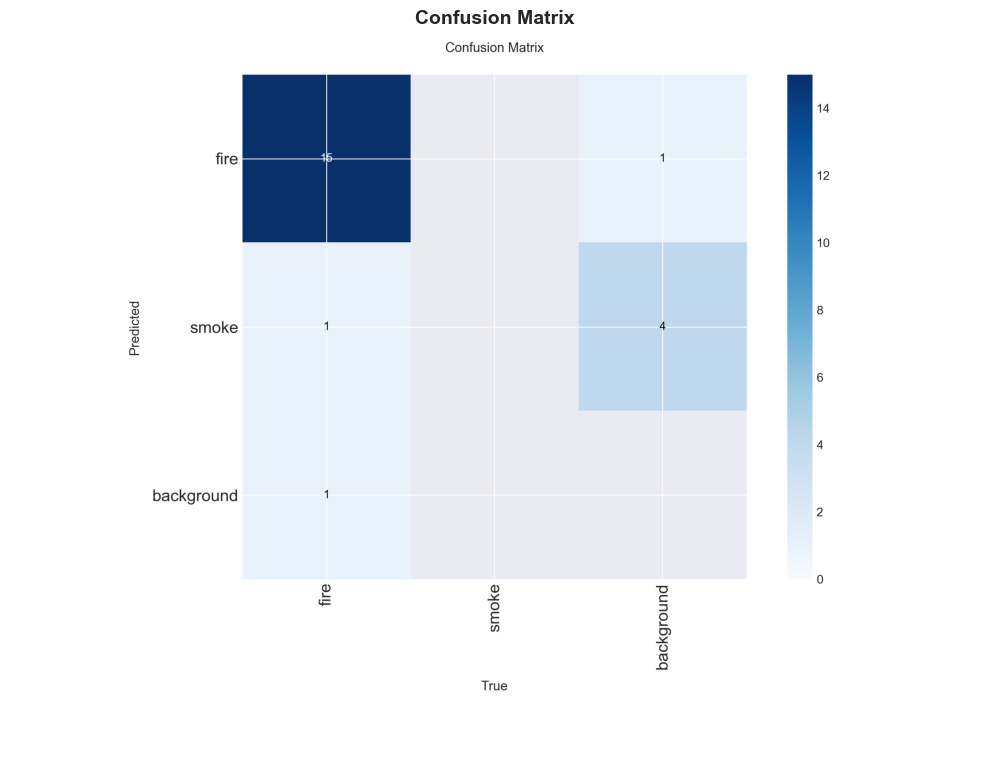

In [80]:
def visualize_validation_results(results_dir: Path):
    """Визуализация результатов валидации"""
    
    print("="*60)
    print("🎨 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
    print("="*60)
    
    # Путь к результатам последней валидации
    val_dir = Path("E:/Python/MIFI/project-practice/notebooks/runs/detect/validation_final_corrected")
    
    if not val_dir.exists():
        # Ищем последнюю директорию валидации
        detect_dir = Path("E:/Python/MIFI/project-practice/notebooks/runs/detect")
        val_dirs = list(detect_dir.glob("validation_*"))
        if val_dirs:
            val_dir = sorted(val_dirs, key=lambda x: x.stat().st_mtime)[-1]
    
    if val_dir.exists():
        print(f"📁 Директория с результатами: {val_dir}")
        
        # Показываем доступные файлы
        print("\n📋 Доступные файлы результатов:")
        for file in val_dir.iterdir():
            if file.is_file():
                print(f"  • {file.name}")
        
        # Загружаем и показываем confusion matrix если есть
        conf_matrix = val_dir / "confusion_matrix.png"
        if conf_matrix.exists():
            from PIL import Image
            import matplotlib.pyplot as plt
            
            img = Image.open(conf_matrix)
            plt.figure(figsize=(10, 8))
            plt.imshow(img)
            plt.axis('off')
            plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
        
        # Показываем графики если есть
        results_csv = val_dir / "results.csv"
        if results_csv.exists():
            import pandas as pd
            import matplotlib.pyplot as plt
            
            df = pd.read_csv(results_csv)
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # График mAP
            if 'metrics/mAP50(B)' in df.columns:
                axes[0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', linewidth=2)
            if 'metrics/mAP50-95(B)' in df.columns:
                axes[0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', linewidth=2)
            
            axes[0].set_title('mAP Metrics', fontweight='bold')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Score')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # График precision/recall
            if 'metrics/precision(B)' in df.columns:
                axes[1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', linewidth=2)
            if 'metrics/recall(B)' in df.columns:
                axes[1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', linewidth=2)
            
            axes[1].set_title('Precision & Recall', fontweight='bold')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Score')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.suptitle('РЕЗУЛЬТАТЫ ВАЛИДАЦИИ МОДЕЛИ', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
        
        # Показываем несколько примеров предсказаний
        predictions_dir = val_dir / "labels"
        if predictions_dir.exists():
            print(f"\n🔍 Примеры предсказаний в: {predictions_dir}")
            
            # Загружаем JSON с результатами если есть
            results_json = val_dir / "results.json"
            if results_json.exists():
                import json
                with open(results_json, 'r', encoding='utf-8') as f:
                    results_data = json.load(f)
                
                print(f"\n📊 Детальные метрики из JSON:")
                if 'metrics' in results_data:
                    for key, value in results_data['metrics'].items():
                        if isinstance(value, (int, float)):
                            print(f"  • {key}: {value:.4f}")
    else:
        print(f"❌ Директория с результатами не найдена: {val_dir}")

# Визуализируем результаты
visualize_validation_results(Path("E:/Python/MIFI/project-practice/notebooks/runs/detect"))

In [81]:
# Сохраняем модель если результаты хорошие
if 'final_results' in locals() and final_results:
    if final_results.get('mAP50', 0) > 0.7:
        model_save_path = Path("E:/Python/MIFI/project-practice/models/trained/best_model.pt")
        model_save_path.parent.mkdir(parents=True, exist_ok=True)
        
        # Сохраняем модель
        trained_model.save(model_save_path)
        print(f"💾 Модель сохранена: {model_save_path}")

💾 Модель сохранена: E:\Python\MIFI\project-practice\models\trained\best_model.pt


In [83]:
def visualize_model_predictions_enhanced(model: YOLO, dataset_dir: Path, split: str = 'valid', n_samples: int = 9, 
                                        save_results: bool = True, show_confidence: bool = True):
    """
    Улучшенная визуализация предсказаний модели YOLO с детальным анализом
    
    Args:
        model: Обученная модель YOLO
        dataset_dir: Путь к директории датасета
        split: Сплит для анализа ('train', 'valid', 'test')
        n_samples: Количество примеров для визуализации
        save_results: Сохранять ли результаты в файл
        show_confidence: Показывать уверенность предсказаний
    """
    
    print(f"\n{'='*60}")
    print(f"📊 УЛУЧШЕННАЯ ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ: {split.upper()}")
    print(f"{'='*60}")
    
    # Определяем пути по вашей структуре
    images_dir = dataset_dir / "images" / split
    labels_dir = dataset_dir / "labels" / split
    
    if not images_dir.exists():
        print(f"⚠️  Директория изображений не найдена: {images_dir}")
        print(f"🔍 Проверяю альтернативные пути...")
        
        # Альтернативные пути для совместимости
        alt_paths = [
            dataset_dir / split / "images",
            dataset_dir / split,
            Path("E:/Python/MIFI/project-practice/flaring-gas") / split
        ]
        
        for alt_path in alt_paths:
            if alt_path.exists():
                images_dir = alt_path
                print(f"✅ Найден альтернативный путь: {images_dir}")
                break
    
    if not labels_dir.exists():
        print(f"⚠️  Директория меток не найдена: {labels_dir}")
        
        # Альтернативные пути для меток
        alt_label_paths = [
            dataset_dir / split / "labels",
            Path("E:/Python/MIFI/project-practice/flaring-gas") / split
        ]
        
        for alt_path in alt_label_paths:
            if alt_path.exists():
                labels_dir = alt_path
                print(f"✅ Найден альтернативный путь для меток: {labels_dir}")
                break
    
    print(f"📁 Изображения: {images_dir}")
    print(f"📝 Метки: {labels_dir}")
    
    # Получаем список изображений
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.JPEG', '.PNG']
    image_files = []
    
    for ext in image_extensions:
        image_files.extend(list(images_dir.glob(f"*{ext}")))
    
    if len(image_files) == 0:
        print(f"❌ Изображения не найдены в {images_dir}")
        # Создаем заглушку для демонстрации
        create_demo_visualization(model)
        return
    
    print(f"📸 Найдено изображений: {len(image_files)}")
    
    # Выбираем изображения
    import random
    n_samples = min(n_samples, len(image_files))
    
    # Стратегия выбора: 1/3 случайных, 1/3 с ошибками, 1/3 лучших
    selected_images = []
    
    if len(image_files) <= n_samples:
        selected_images = image_files
    else:
        # Первые 3 случайных
        selected_images.extend(random.sample(image_files, min(3, n_samples)))
        
        # Пробуем найти изображения с метками для анализа
        images_with_labels = []
        for img_file in image_files:
            label_file = labels_dir / f"{img_file.stem}.txt"
            if label_file.exists():
                images_with_labels.append(img_file)
        
        if images_with_labels:
            # Добавляем несколько изображений с метками
            n_with_labels = min(3, n_samples - len(selected_images), len(images_with_labels))
            selected_images.extend(random.sample(images_with_labels, n_with_labels))
        
        # Добираем до нужного количества
        remaining = n_samples - len(selected_images)
        if remaining > 0:
            other_images = [img for img in image_files if img not in selected_images]
            if other_images:
                selected_images.extend(random.sample(other_images, min(remaining, len(other_images))))
    
    # Создаем сетку для визуализации
    n_cols = 3
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
    
    # Если только одна строка
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    # Статистика для анализа
    stats = {
        'total_images': len(selected_images),
        'images_with_gt': 0,
        'images_with_predictions': 0,
        'total_gt_boxes': 0,
        'total_pred_boxes': 0,
        'correct_detections': 0,
        'false_positives': 0,
        'false_negatives': 0
    }
    
    # Цветовая схема
    colors = {
        'gt': {'box': 'lime', 'text': 'green'},
        'pred_correct': {'box': 'red', 'text': 'darkred'},
        'pred_fp': {'box': 'orange', 'text': 'darkorange'},
        'pred_confident': {'box': 'cyan', 'text': 'blue'},
        'background': {'box': 'gray', 'text': 'gray'}
    }
    
    class_names = model.names if hasattr(model, 'names') else {0: 'flare', 1: 'fire'}
    
    for idx, img_path in enumerate(selected_images):
        ax = axes[idx] if idx < len(axes) else None
        if ax is None:
            continue
        
        try:
            # Загружаем изображение
            img = Image.open(img_path)
            img_array = np.array(img)
            ax.imshow(img_array)
            
            # Получаем Ground Truth
            gt_boxes = []
            label_path = labels_dir / f"{img_path.stem}.txt"
            
            if label_path.exists():
                stats['images_with_gt'] += 1
                with open(label_path, 'r', encoding='utf-8') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            class_id = int(float(parts[0]))
                            x_center, y_center, width, height = map(float, parts[1:5])
                            gt_boxes.append({
                                'class_id': class_id,
                                'bbox': [x_center, y_center, width, height],
                                'class_name': class_names.get(class_id, f'class_{class_id}')
                            })
                            stats['total_gt_boxes'] += 1
            
            # Получаем предсказания модели
            results = model.predict(
                source=str(img_path),
                conf=0.25,  # Порог уверенности
                iou=0.45,   # Порог NMS
                device='cpu',  # Явно указываем устройство
                verbose=False,
                save=False
            )
            
            pred_boxes = []
            if results and len(results) > 0:
                boxes_data = results[0].boxes
                if boxes_data is not None and len(boxes_data) > 0:
                    stats['images_with_predictions'] += 1
                    
                    for box_idx in range(len(boxes_data)):
                        box = boxes_data[box_idx]
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        confidence = float(box.conf[0].cpu().numpy())
                        class_id = int(box.cls[0].cpu().numpy())
                        
                        # Конвертируем в YOLO формат для сравнения
                        img_width, img_height = img.size
                        x_center = ((x1 + x2) / 2) / img_width
                        y_center = ((y1 + y2) / 2) / img_height
                        width = (x2 - x1) / img_width
                        height = (y2 - y1) / img_height
                        
                        pred_boxes.append({
                            'bbox_abs': [x1, y1, x2, y2],
                            'bbox_norm': [x_center, y_center, width, height],
                            'confidence': confidence,
                            'class_id': class_id,
                            'class_name': class_names.get(class_id, f'class_{class_id}'),
                            'matched': False  # Для отслеживания совпадений
                        })
                        
                        stats['total_pred_boxes'] += 1
            
            # Рисуем Ground Truth (зеленые)
            for gt_box in gt_boxes:
                x_center, y_center, width, height = gt_box['bbox']
                
                # Конвертируем в абсолютные координаты
                x1 = (x_center - width/2) * img.size[0]
                y1 = (y_center - height/2) * img.size[1]
                w = width * img.size[0]
                h = height * img.size[1]
                
                # Рисуем bounding box
                rect = plt.Rectangle((x1, y1), w, h, linewidth=2,
                                   edgecolor=colors['gt']['box'], 
                                   facecolor='none', 
                                   linestyle='--',
                                   alpha=0.7)
                ax.add_patch(rect)
                
                # Подпись для Ground Truth
                label = f"GT: {gt_box['class_name']}"
                ax.text(x1, y1 - 5, label, 
                       fontsize=9, fontweight='bold',
                       color=colors['gt']['text'],
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            
            # Простое сопоставление предсказаний с Ground Truth
            matched_pred_indices = set()
            
            for gt_idx, gt_box in enumerate(gt_boxes):
                gt_bbox_norm = gt_box['bbox']
                best_match_idx = -1
                best_iou = 0.3  # Порог IoU для совпадения
                
                for pred_idx, pred_box in enumerate(pred_boxes):
                    if pred_idx in matched_pred_indices:
                        continue
                    
                    # Вычисляем IoU
                    iou = calculate_iou(gt_bbox_norm, pred_box['bbox_norm'])
                    
                    if iou > best_iou and gt_box['class_id'] == pred_box['class_id']:
                        best_iou = iou
                        best_match_idx = pred_idx
                
                if best_match_idx != -1:
                    matched_pred_indices.add(best_match_idx)
                    pred_boxes[best_match_idx]['matched'] = True
                    stats['correct_detections'] += 1
            
            # Рисуем предсказания
            for pred_idx, pred_box in enumerate(pred_boxes):
                x1, y1, x2, y2 = pred_box['bbox_abs']
                confidence = pred_box['confidence']
                class_name = pred_box['class_name']
                is_matched = pred_box['matched']
                
                # Определяем цвет в зависимости от результата
                if is_matched:
                    color_scheme = colors['pred_correct']
                    label_prefix = "✓ "
                elif confidence > 0.7:
                    color_scheme = colors['pred_confident']
                    label_prefix = "⚡ "
                else:
                    color_scheme = colors['pred_fp']
                    label_prefix = "? "
                    if not is_matched:
                        stats['false_positives'] += 1
                
                # Рисуем bounding box
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   linewidth=2,
                                   edgecolor=color_scheme['box'],
                                   facecolor='none',
                                   alpha=0.8)
                ax.add_patch(rect)
                
                # Подпись с классом и уверенностью
                if show_confidence:
                    label = f"{label_prefix}{class_name}: {confidence:.2f}"
                else:
                    label = f"{label_prefix}{class_name}"
                
                ax.text(x1, y1 - 5, label,
                       fontsize=9, fontweight='bold',
                       color=color_scheme['text'],
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            
            # Вычисляем false negatives
            stats['false_negatives'] += len(gt_boxes) - len(matched_pred_indices)
            
            # Заголовок изображения с статистикой
            title = f"{img_path.name}\n"
            title += f"GT: {len(gt_boxes)}, Pred: {len(pred_boxes)}"
            if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                precision = len(matched_pred_indices) / len(pred_boxes) if len(pred_boxes) > 0 else 0
                recall = len(matched_pred_indices) / len(gt_boxes) if len(gt_boxes) > 0 else 0
                title += f", P: {precision:.2f}, R: {recall:.2f}"
            
            ax.set_title(title, fontsize=10, pad=10)
            
        except Exception as e:
            ax.clear()
            ax.text(0.5, 0.5, f"Ошибка:\n{str(e)[:50]}...",
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=9, color='red')
            ax.set_title(f"{img_path.name}", fontsize=10)
        
        ax.axis('off')
    
    # Скрываем лишние оси
    for idx in range(len(selected_images), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'АНАЛИЗ ПРЕДСКАЗАНИЙ МОДЕЛИ: {split.upper()}\n'
                f'🟢 Ground Truth (пунктир) | 🔴 Предсказания (сплошной) | ⚡ Высокая уверенность',
                fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    # Сохраняем результат если нужно
    if save_results:
        output_dir = Path("E:/Python/MIFI/project-practice/notebooks/visualizations")
        output_dir.mkdir(parents=True, exist_ok=True)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_path = output_dir / f"predictions_{split}_{timestamp}.png"
        
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"💾 Визуализация сохранена: {output_path}")
    
    plt.show()
    
    # Выводим статистику
    print(f"\n📈 СТАТИСТИКА АНАЛИЗА ({split.upper()}):")
    print(f"{'='*40}")
    print(f"• Изображений проанализировано: {stats['total_images']}")
    print(f"• Изображений с Ground Truth: {stats['images_with_gt']}")
    print(f"• Изображений с предсказаниями: {stats['images_with_predictions']}")
    print(f"• Всего GT боксов: {stats['total_gt_boxes']}")
    print(f"• Всего предсказанных боксов: {stats['total_pred_boxes']}")
    
    if stats['total_pred_boxes'] > 0:
        precision = stats['correct_detections'] / stats['total_pred_boxes'] * 100
        print(f"• Правильных детекций: {stats['correct_detections']} ({precision:.1f}%)")
    
    if stats['total_gt_boxes'] > 0:
        recall = stats['correct_detections'] / stats['total_gt_boxes'] * 100
        print(f"• Пропущенных объектов (FN): {stats['false_negatives']} ({100-recall:.1f}%)")
    
    print(f"• Ложных срабатываний (FP): {stats['false_positives']}")
    
    # Рекомендации на основе статистики
    print(f"\n💡 РЕКОМЕНДАЦИИ:")
    
    if stats['false_positives'] > stats['correct_detections']:
        print("  • ⚠️  Много ложных срабатываний: увеличьте порог уверенности (conf)")
    
    if stats['false_negatives'] > stats['correct_detections']:
        print("  • ⚠️  Много пропущенных объектов: уменьшите порог уверенности")
    
    if stats['images_with_predictions'] == 0:
        print("  • ⚠️  Модель не делает предсказаний: проверьте порог уверенности")
    
    if stats['correct_detections'] > 0 and stats['false_positives'] == 0:
        print("  • ✅ Отличная точность! Модель работает хорошо")

def calculate_iou(bbox1, bbox2):
    """Вычисляет Intersection over Union для двух bounding box в нормализованных координатах"""
    # bbox: [x_center, y_center, width, height]
    
    # Конвертируем в [x1, y1, x2, y2]
    x1_1 = bbox1[0] - bbox1[2] / 2
    y1_1 = bbox1[1] - bbox1[3] / 2
    x2_1 = bbox1[0] + bbox1[2] / 2
    y2_1 = bbox1[1] + bbox1[3] / 2
    
    x1_2 = bbox2[0] - bbox2[2] / 2
    y1_2 = bbox2[1] - bbox2[3] / 2
    x2_2 = bbox2[0] + bbox2[2] / 2
    y2_2 = bbox2[1] + bbox2[3] / 2
    
    # Вычисляем площадь пересечения
    x_left = max(x1_1, x1_2)
    y_top = max(y1_1, y1_2)
    x_right = min(x2_1, x2_2)
    y_bottom = min(y2_1, y2_2)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Вычисляем площадь объединения
    bbox1_area = bbox1[2] * bbox1[3]
    bbox2_area = bbox2[2] * bbox2[3]
    union_area = bbox1_area + bbox2_area - intersection_area
    
    return intersection_area / union_area if union_area > 0 else 0.0

def create_demo_visualization(model):
    """Создает демонстрационную визуализацию если данных нет"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    demo_texts = [
        "📁 Данные не найдены\nПроверьте пути к изображениям",
        "🔧 Пример структуры:\ndataset/\n  images/\n    train/\n    valid/\n  labels/\n    train/\n    valid/",
        "💡 Создайте YAML файл:\npath: /your/path\ntrain: images/train\nval: images/valid\nnc: 2\nnames: ['flare', 'fire']"
    ]
    
    for ax, text in zip(axes, demo_texts):
        ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12)
        ax.axis('off')
    
    plt.suptitle("ДЕМОНСТРАЦИЯ ВИЗУАЛИЗАЦИИ ПРЕДСКАЗАНИЙ", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


📊 УЛУЧШЕННАЯ ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ: VALID
📁 Изображения: E:\Python\MIFI\project-practice\yolo_dataset_structured\images\valid
📝 Метки: E:\Python\MIFI\project-practice\yolo_dataset_structured\labels\valid
📸 Найдено изображений: 80
💾 Визуализация сохранена: E:\Python\MIFI\project-practice\notebooks\visualizations\predictions_valid_20251215_115533.png


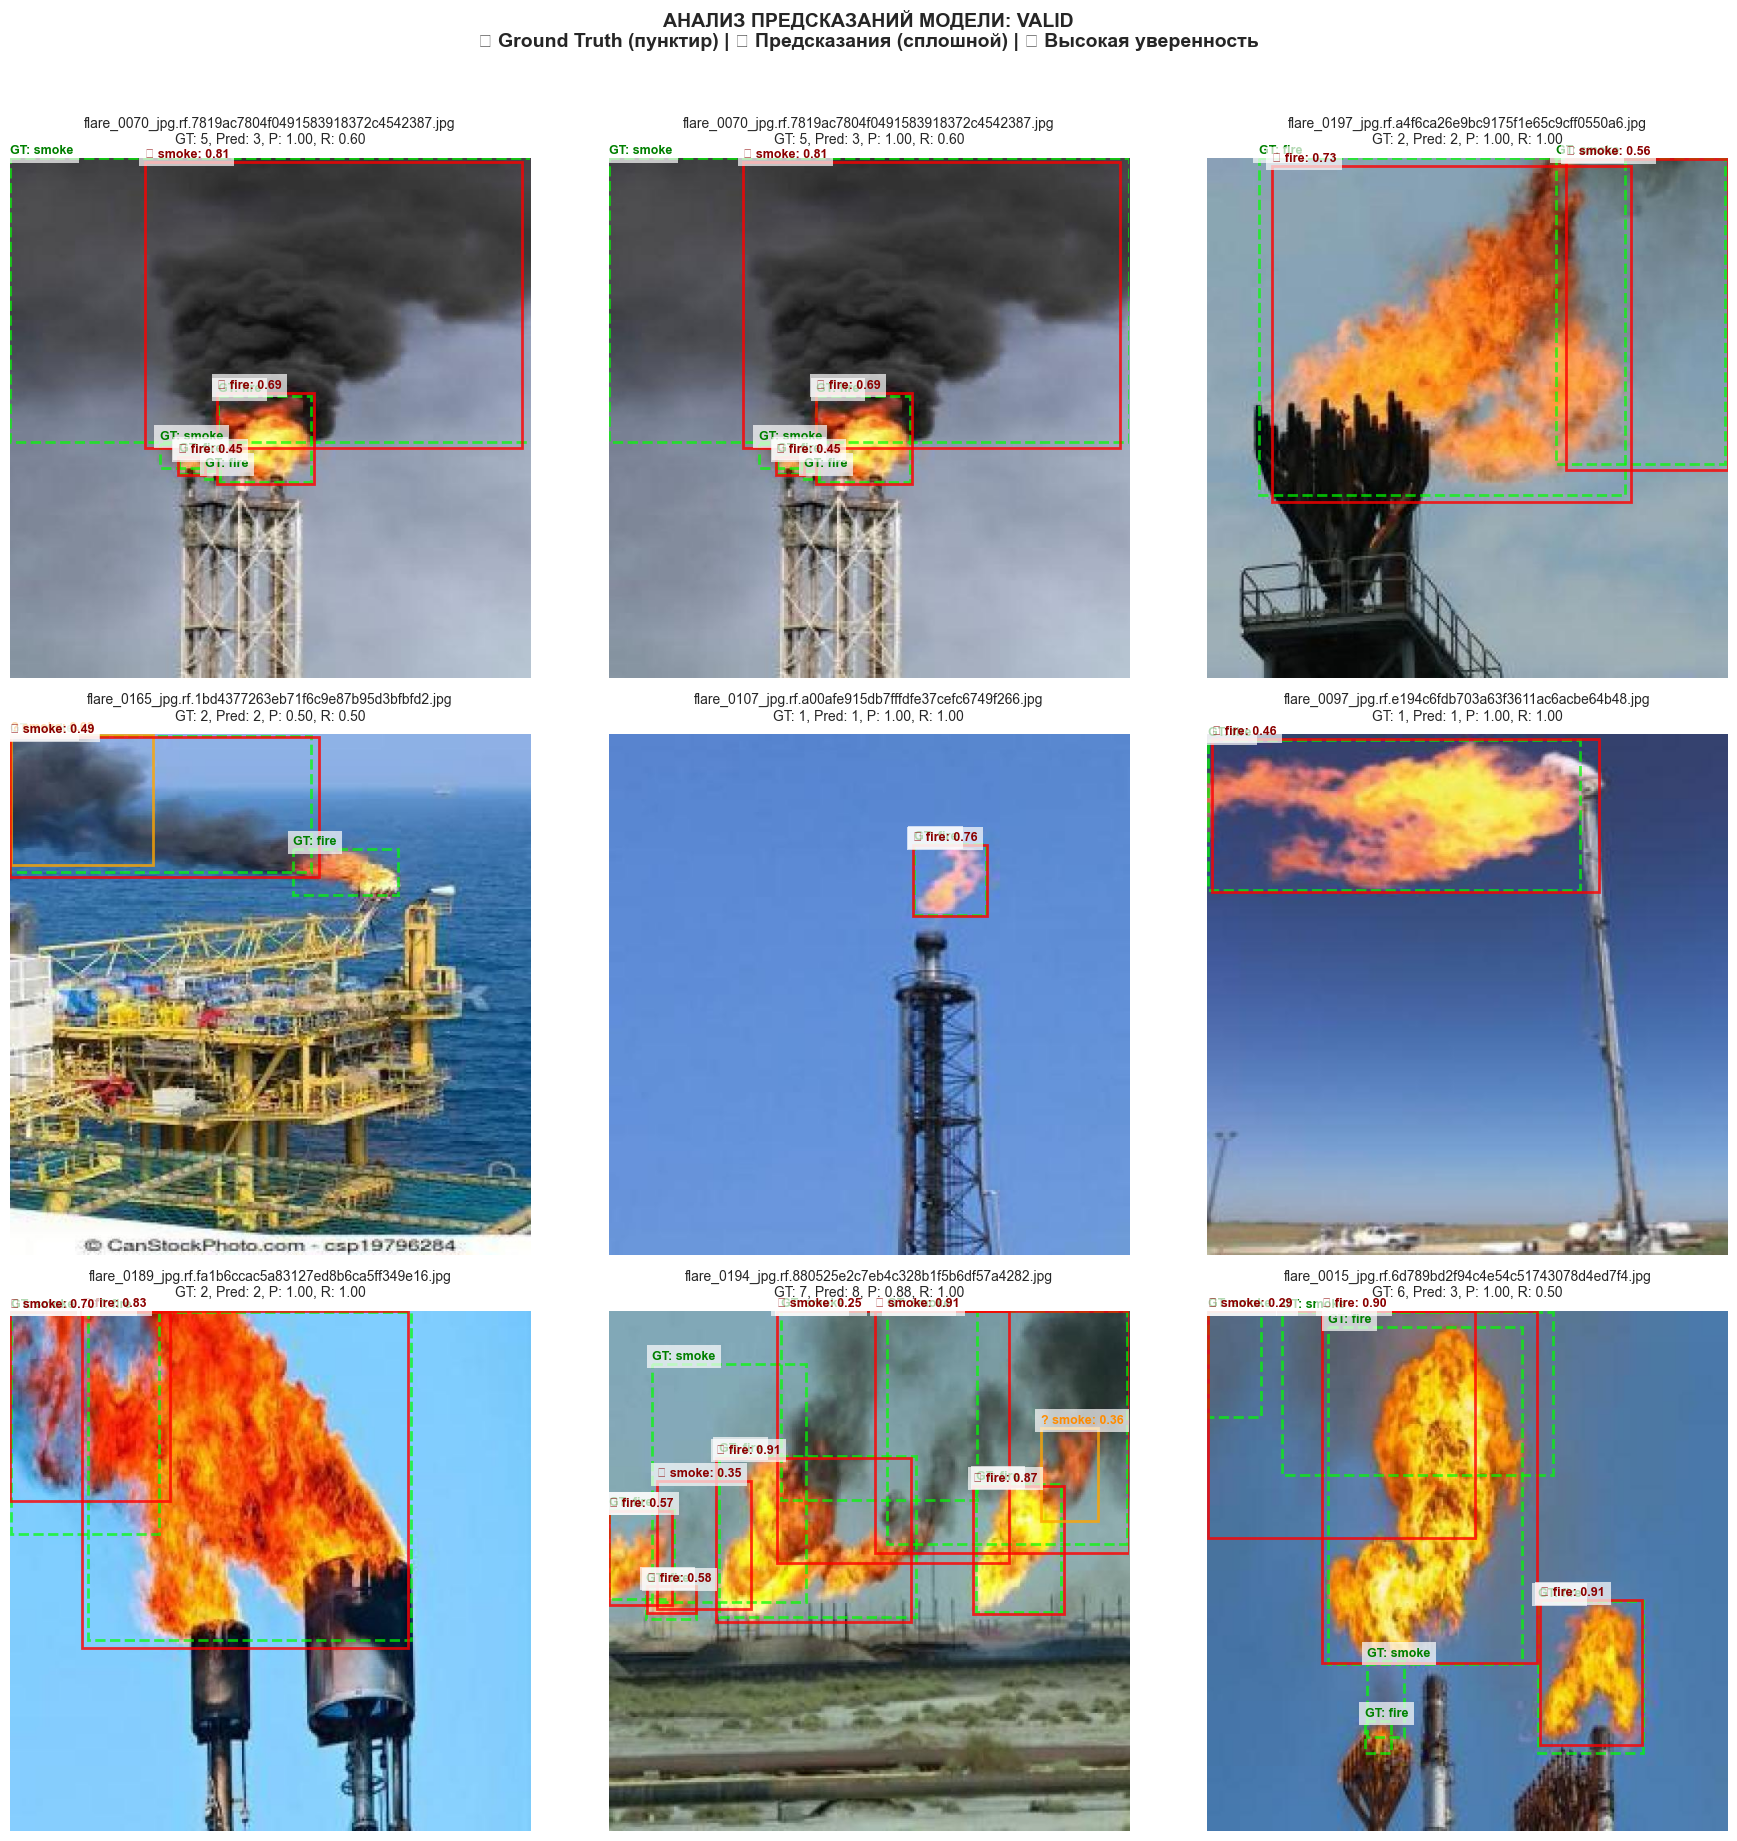


📈 СТАТИСТИКА АНАЛИЗА (VALID):
• Изображений проанализировано: 9
• Изображений с Ground Truth: 9
• Изображений с предсказаниями: 9
• Всего GT боксов: 31
• Всего предсказанных боксов: 25
• Правильных детекций: 23 (92.0%)
• Пропущенных объектов (FN): 8 (25.8%)
• Ложных срабатываний (FP): 2

💡 РЕКОМЕНДАЦИИ:

📊 УЛУЧШЕННАЯ ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ: TRAIN
📁 Изображения: E:\Python\MIFI\project-practice\yolo_dataset_structured\images\train
📝 Метки: E:\Python\MIFI\project-practice\yolo_dataset_structured\labels\train
📸 Найдено изображений: 1974
💾 Визуализация сохранена: E:\Python\MIFI\project-practice\notebooks\visualizations\predictions_train_20251215_115537.png


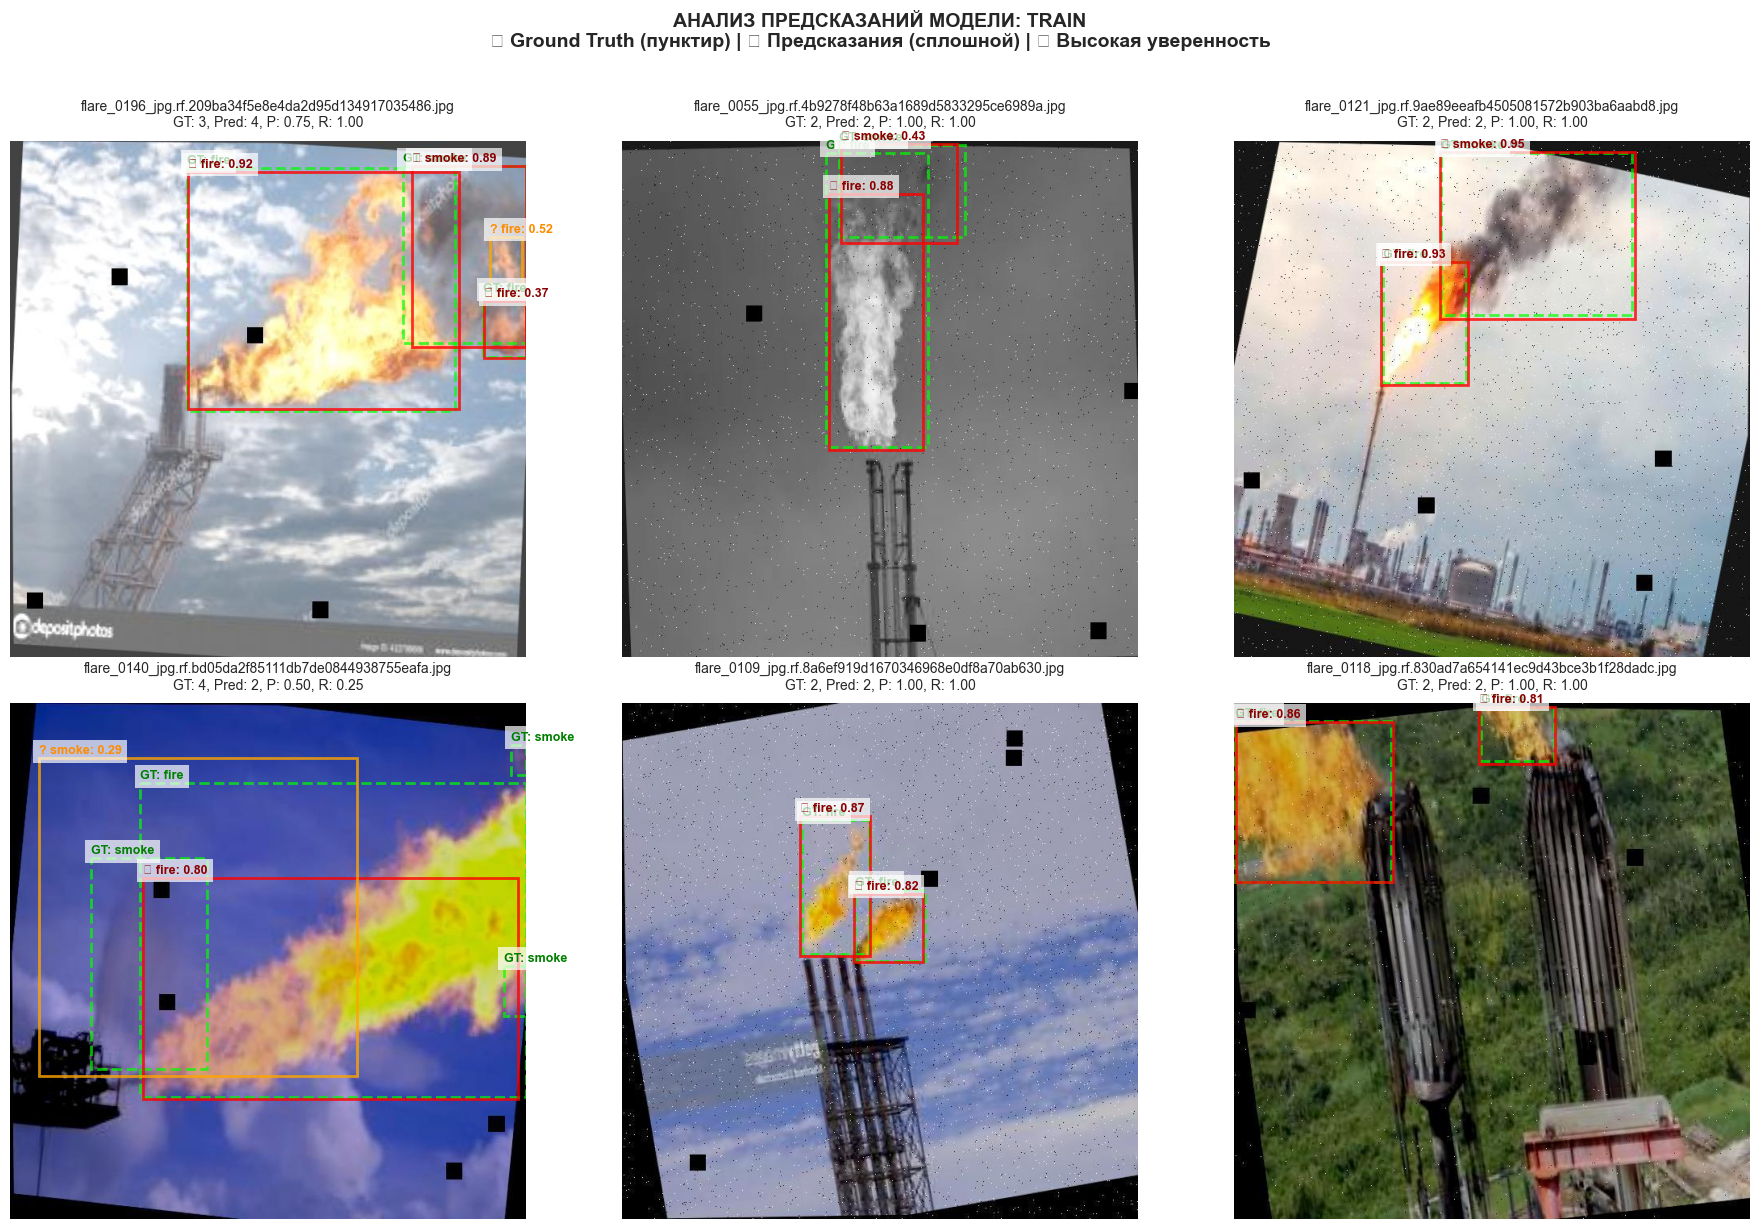


📈 СТАТИСТИКА АНАЛИЗА (TRAIN):
• Изображений проанализировано: 6
• Изображений с Ground Truth: 6
• Изображений с предсказаниями: 6
• Всего GT боксов: 15
• Всего предсказанных боксов: 14
• Правильных детекций: 12 (85.7%)
• Пропущенных объектов (FN): 3 (20.0%)
• Ложных срабатываний (FP): 2

💡 РЕКОМЕНДАЦИИ:


In [84]:
if 'trained_model' in locals() and trained_model is not None:
    # Определяем путь к датасету
    dataset_path = Path("E:/Python/MIFI/project-practice/yolo_dataset_structured")
    
    # Визуализируем предсказания на валидационных данных
    visualize_model_predictions_enhanced(
        model=trained_model,
        dataset_dir=dataset_path,
        split='valid',  # 'train', 'valid', или 'test'
        n_samples=9,    # Количество изображений для показа
        save_results=True,
        show_confidence=True
    )
    
    # Можно также проанализировать тренировочные данные
    if (dataset_path / "images" / "train").exists():
        visualize_model_predictions_enhanced(
            model=trained_model,
            dataset_dir=dataset_path,
            split='train',
            n_samples=6,
            save_results=True,
            show_confidence=True
        )

In [85]:
print("\n" + "="*60)
print("СЛЕДУЮЩИЕ ЭТАПЫ ПРОЕКТА")
print("="*60)

print('''
📋 ПЛАН ДАЛЬНЕЙШЕЙ РАБОТЫ:

1. ИНТЕГРАЦИЯ МОДЕЛИ В ПАЙПЛАЙН:
   • Создание скрипта для пакетной обработки изображений
   • Интеграция с пайплайном расчета выбросов
   • Оптимизация производительности для реального времени

2. РАСЧЕТ МЕТРИК ВЫБРОСОВ:
   • Калибровка модели (пиксели → реальные размеры)
   • Расчет объема выбросов на основе площади факелов
   • Учет перспективы и расстояния

3. ВАЛИДАЦИЯ НА РЕАЛЬНЫХ ДАННЫХ:
   • Тестирование на новых, неразмеченных изображениях
   • Сравнение с ручной разметкой экспертов
   • Оценка в различных условиях (день/ночь, погода)

4. УЛУЧШЕНИЕ МОДЕЛИ:
   • Сбор дополнительных данных для сложных случаев
   • Эксперименты с другими архитектурами
   • Оптимизация для edge-устройств (если требуется)

5. РАЗРАБОТКА ИНТЕРФЕЙСА:
   • Веб-интерфейс для загрузки и анализа изображений
   • Визуализация результатов детекции
   • Экспорт отчетов ''')


СЛЕДУЮЩИЕ ЭТАПЫ ПРОЕКТА

📋 ПЛАН ДАЛЬНЕЙШЕЙ РАБОТЫ:

1. ИНТЕГРАЦИЯ МОДЕЛИ В ПАЙПЛАЙН:
   • Создание скрипта для пакетной обработки изображений
   • Интеграция с пайплайном расчета выбросов
   • Оптимизация производительности для реального времени

2. РАСЧЕТ МЕТРИК ВЫБРОСОВ:
   • Калибровка модели (пиксели → реальные размеры)
   • Расчет объема выбросов на основе площади факелов
   • Учет перспективы и расстояния

3. ВАЛИДАЦИЯ НА РЕАЛЬНЫХ ДАННЫХ:
   • Тестирование на новых, неразмеченных изображениях
   • Сравнение с ручной разметкой экспертов
   • Оценка в различных условиях (день/ночь, погода)

4. УЛУЧШЕНИЕ МОДЕЛИ:
   • Сбор дополнительных данных для сложных случаев
   • Эксперименты с другими архитектурами
   • Оптимизация для edge-устройств (если требуется)

5. РАЗРАБОТКА ИНТЕРФЕЙСА:
   • Веб-интерфейс для загрузки и анализа изображений
   • Визуализация результатов детекции
   • Экспорт отчетов 
